In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
# Load TTC subway delay data
ttc_delays_path = 'delays_combined.csv'
delay_codes_path = 'ttc-subway-delay-codes.csv'

In [ ]:
ttc_delays = pd.read_csv(ttc_delays_path)
delay_codes = pd.read_csv(delay_codes_path)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[TTC Subway Map](ttc-subway-map.png)'


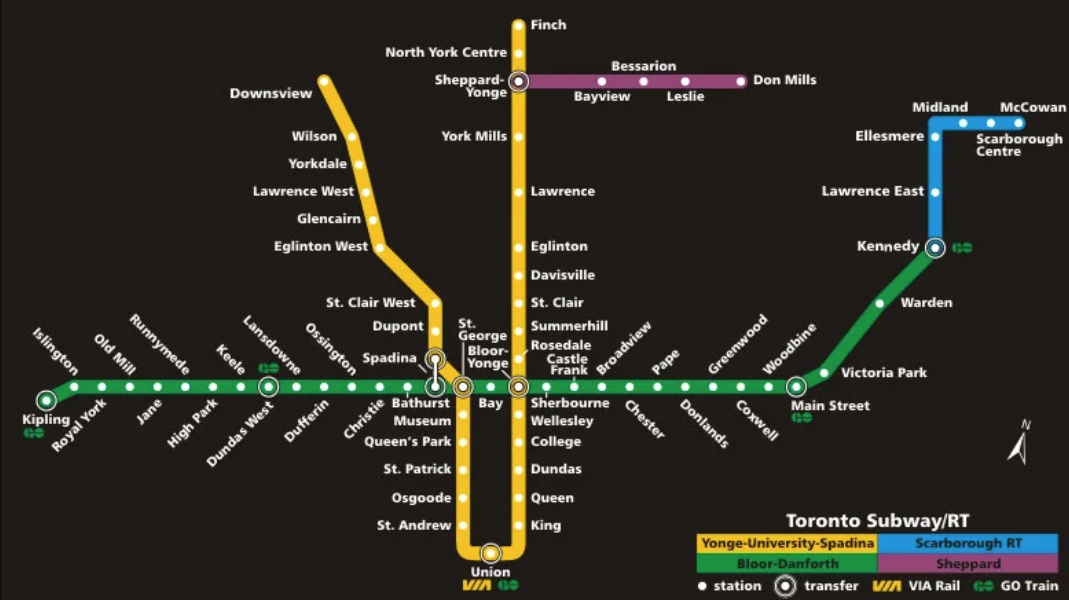

In [ ]:
![TTC Subway Map](ttc-subway-map.png)
from IPython.display import Image, display

display(Image(filename='ttc-subway-map.png'))

In [ ]:
# Data cleaning: rename and merge station names
station_renaming = {
    "KENNEDY BD STATION": "KENNEDY STATION",
    "BLOOR STATION": "YONGE-BLOOR STATION",
    "YONGE UNIVERSITY LINE": "YONGE-BLOOR STATION",
    "YONGE BD STATION": "YONGE-BLOOR STATION",
    "ST GEORGE YUS STATION": "ST GEORGE STATION"
}

ttc_delays['Station'] = ttc_delays['Station'].replace(station_renaming)

# Save the updated data to a new CSV file
output_path = 'updated_ttc_delays.csv'
ttc_delays.to_csv(output_path, index=False)

print(f"Updated data saved to {output_path}")

Updated data saved to updated_ttc_delays.csv


In [ ]:
# Clean column names in the delay_codes dataset
delay_codes.columns = delay_codes.columns.str.strip()
delay_codes.columns = delay_codes.columns.str.upper()

# Clean and rename relevant columns in delay codes
delay_codes_cleaned = delay_codes[['SUB RMENU CODE', 'CODE DESCRIPTION']].rename(
    columns={'SUB RMENU CODE': 'CODE', 'CODE DESCRIPTION': 'DESCRIPTION'}
).drop_duplicates()

# Check for missing or duplicate values in the TTC delays dataset
print("Missing values in TTC delays dataset:")
print(ttc_delays.isnull().sum())

# Remove duplicate rows from TTC delays dataset
ttc_delays_cleaned = ttc_delays.drop_duplicates()

print(delay_codes_cleaned.head())  # Preview cleaned delay codes
print(ttc_delays_cleaned.head())  # Preview cleaned TTC delays


Missing values in TTC delays dataset:
Date                0
Time                0
Day                 0
Station             0
Code                1
Min Delay           0
Min Gap             0
Bound           56466
Line              684
Vehicle             0
Unnamed: 10    217879
Unnamed: 11    217879
Unnamed: 12    217879
dtype: int64
    CODE          DESCRIPTION
0   EUAC     Air Conditioning
1   EUAL  Alternating Current
2  EUATC   ATC RC&S Equipment
3   EUBK               Brakes
4   EUBO                 Body
         Date  Time        Day                Station   Code  Min Delay  \
0  2014-01-01  0:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1  2014-01-01  2:06  Wednesday      HIGH PARK STATION   SUDP          3   
2  2014-01-01  2:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3  2014-01-01  3:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4  2014-01-01  3:20  Wednesday    YONGE-BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle  

In [ ]:
ttc_merged = ttc_delays.merge(
    delay_codes_cleaned, how='left', left_on='Code', right_on='CODE'
).drop(columns=['CODE'])

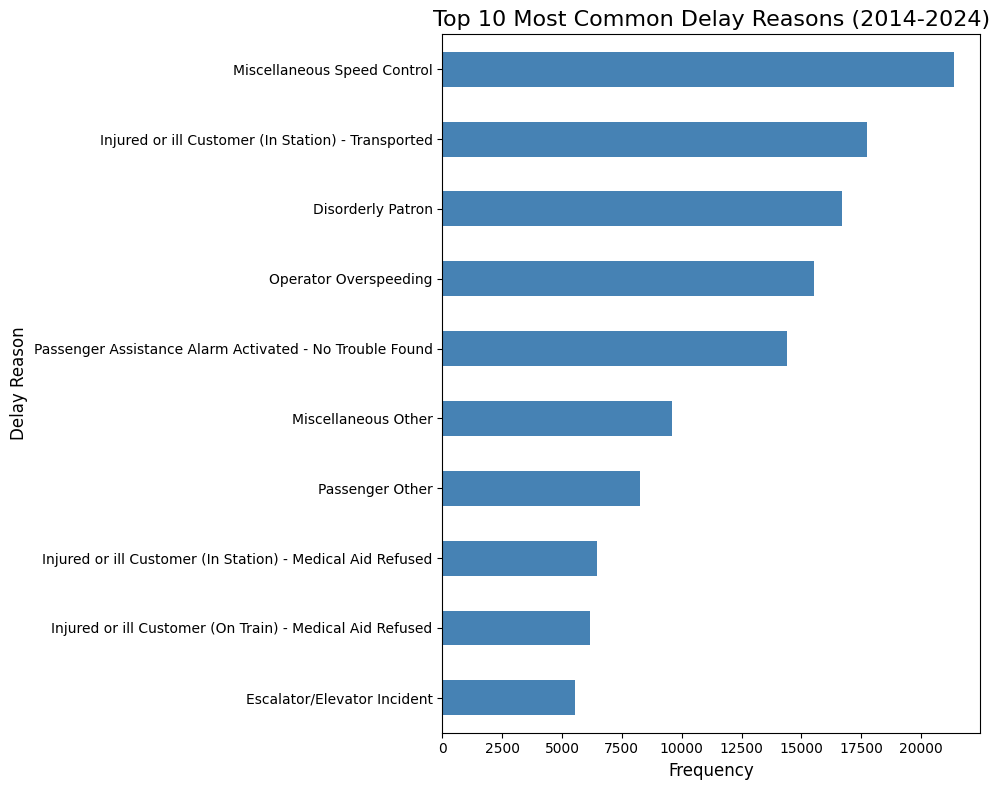

In [ ]:
# Count and visualize the most common delay reasons
top_delay_reasons = (
    ttc_merged['DESCRIPTION']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  # Sort for better visualization
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_delay_reasons.plot(kind='barh', color='steelblue')
plt.title('Top 10 Most Common Delay Reasons (2014-2024)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Delay Reason', fontsize=12)
plt.tight_layout()
plt.show()

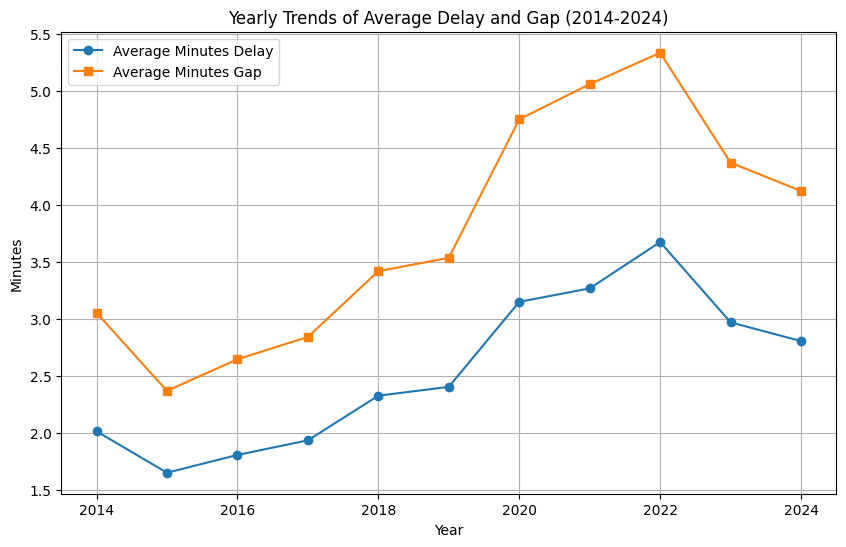

In [ ]:
# Extract year from the 'Date' column
ttc_delays_merged = ttc_delays.merge(
    delay_codes_cleaned, how='left', left_on='Code', right_on='CODE'
).drop(columns=['CODE'])
ttc_delays_merged['Year'] = pd.to_datetime(ttc_delays_merged['Date'], errors='coerce').dt.year

yearly_delays = ttc_delays_merged.groupby('Year')[['Min Delay', 'Min Gap']].mean().reset_index()
line_direction_delays = ttc_delays_merged.groupby(['Line', 'Bound'])[['Min Delay']].mean().reset_index()
station_delays = ttc_delays_merged.groupby('Station')[['Min Delay']].sum().sort_values(by='Min Delay', ascending=False).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_delays['Year'], yearly_delays['Min Delay'], marker='o', label='Average Minutes Delay')
plt.plot(yearly_delays['Year'], yearly_delays['Min Gap'], marker='s', label='Average Minutes Gap')
plt.title('Yearly Trends of Average Delay and Gap (2014-2024)')
plt.xlabel('Year')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ttc_merged['Hour'] = pd.to_datetime(ttc_merged['Time'], errors='coerce').dt.hour

<ipython-input-10-0d5e4fa0b19f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc_merged['Hour'] = pd.to_datetime(ttc_merged['Time'], errors='coerce').dt.hour


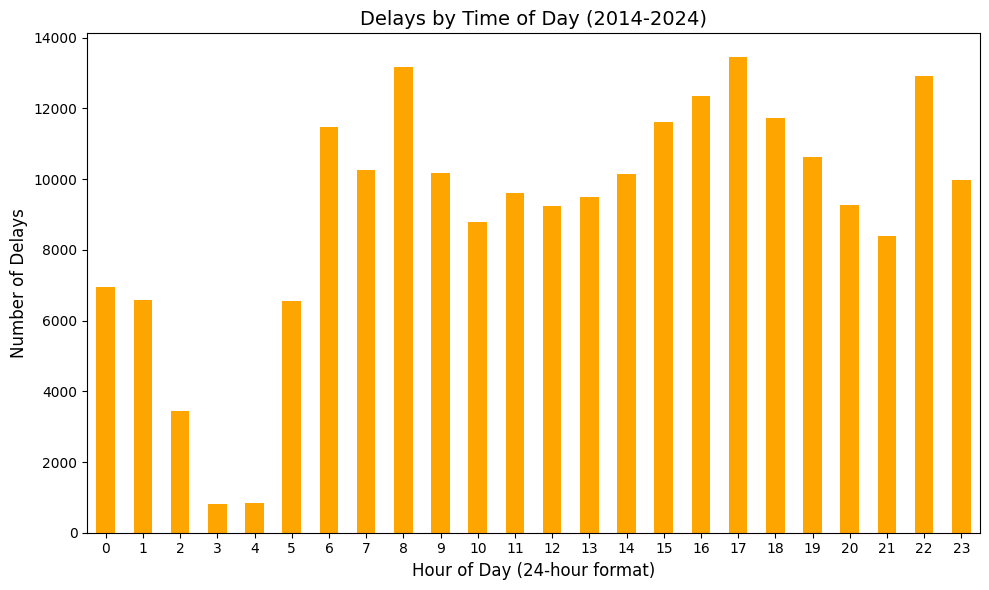

In [ ]:
time_of_day_delays = ttc_merged.groupby('Hour').size()
plt.figure(figsize=(10, 6))
time_of_day_delays.plot(kind='bar', color='orange')
plt.title('Delays by Time of Day (2014-2024)', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

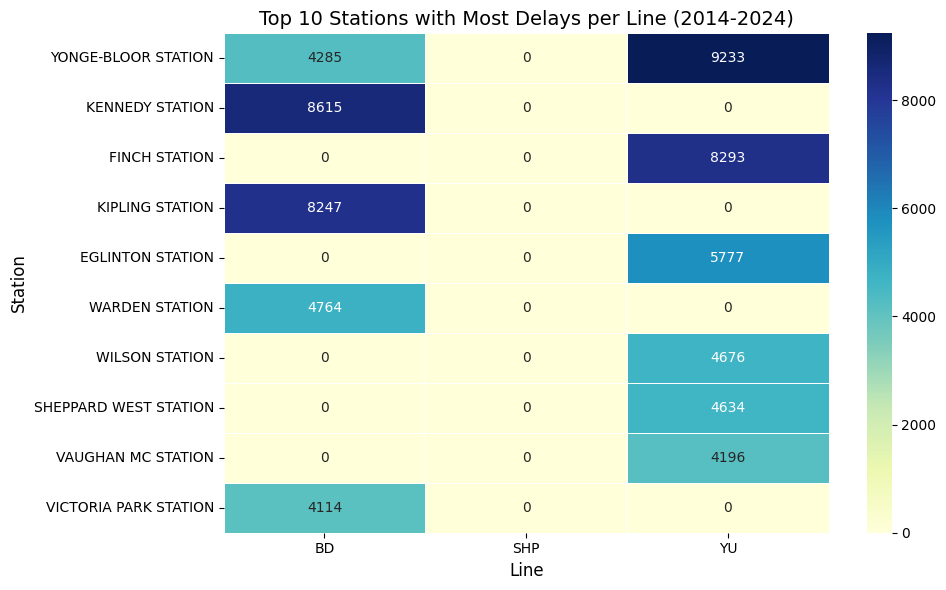

In [23]:
ttc_delays['Station'] = ttc_delays['Station'].replace(station_renaming)

# Define valid subway lines and update station-to-line mapping
valid_lines = ['YU', 'BD', 'SHP']
station_to_line_mapping = {
    "YONGE-BLOOR STATION": ["BD", "YU"],
    "KENNEDY STATION": ["BD"],
    "FINCH STATION": ["YU"],
    "KIPLING STATION": ["BD"],
    "EGLINTON STATION": ["YU"],
    "WARDEN STATION": ["BD"],
    "WILSON STATION": ["YU"],
    "SHEPPARD WEST STATION": ["YU"],
    "VAUGHAN MC STATION": ["YU"],
    "VICTORIA PARK STATION": ["BD"],
}

# Ensure the 'Line' column contains only valid lines
ttc_delays = ttc_delays[ttc_delays['Line'].isin(valid_lines)]

# Function to validate station-line mapping
def validate_station_line(row):
    station = row["Station"]
    line = row["Line"]
    if station in station_to_line_mapping:
        return line in station_to_line_mapping[station]
    return True

valid_ttc_delays = ttc_delays[ttc_delays.apply(validate_station_line, axis=1)]

delay_counts = valid_ttc_delays.pivot_table(
    index="Station",
    columns="Line",
    values="Min Delay",
    aggfunc="count",
    fill_value=0
)

top_10_stations = delay_counts.sum(axis=1).sort_values(ascending=False).head(10).index
delay_counts_top_10 = delay_counts.loc[top_10_stations]

plt.figure(figsize=(10, 6))
sns.heatmap(
    delay_counts_top_10,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar=True,
    annot_kws={"size": 10},
)
plt.title("Top 10 Stations with Most Delays per Line (2014-2024)", fontsize=14)
plt.ylabel("Station", fontsize=12)
plt.xlabel("Line", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()



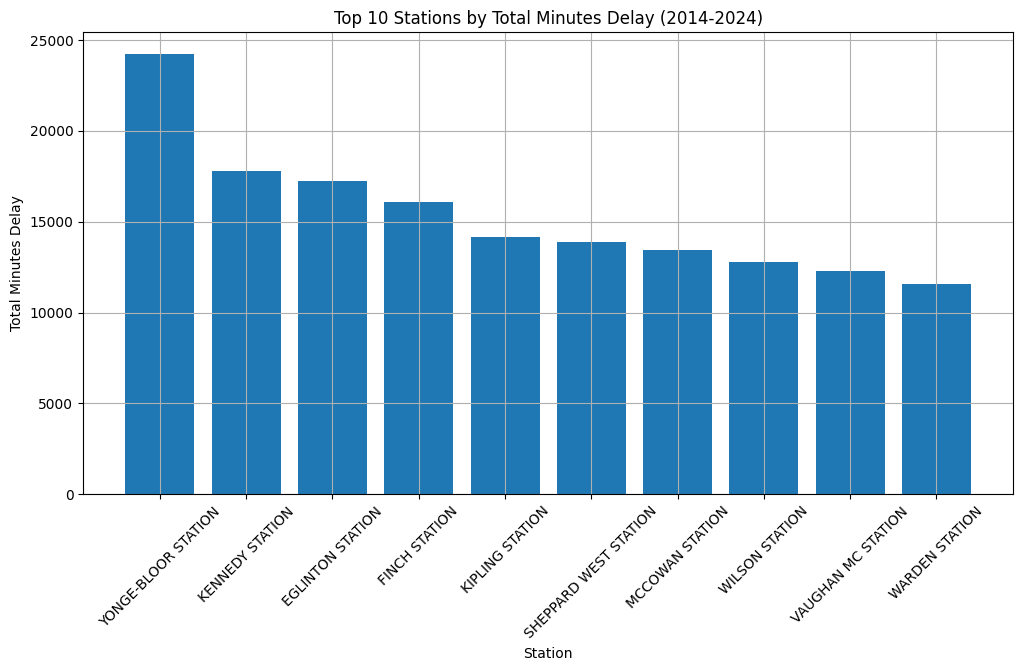

In [ ]:
plt.figure(figsize=(12, 6))
top_stations = station_delays.head(10)
plt.bar(top_stations['Station'], top_stations['Min Delay'])
plt.title('Top 10 Stations by Total Minutes Delay (2014-2024)')
plt.xlabel('Station')
plt.ylabel('Total Minutes Delay')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

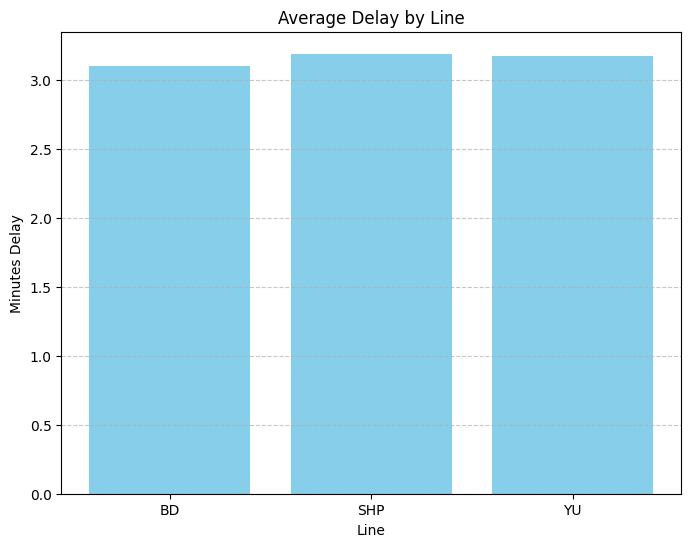

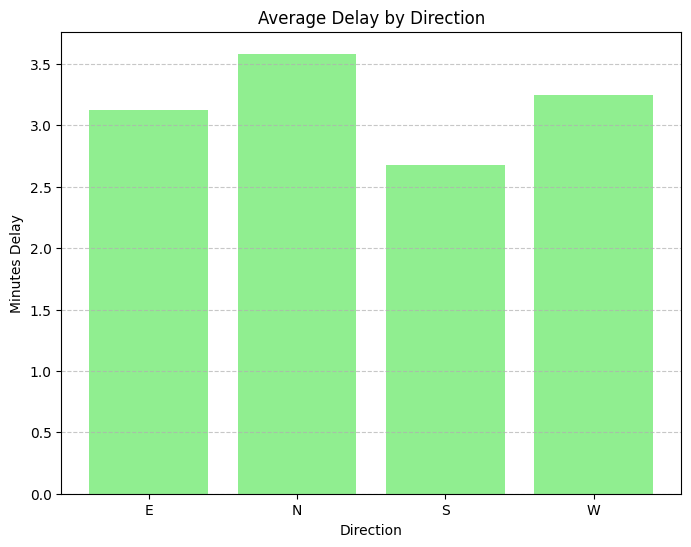

In [ ]:
 # Filter line_direction_delays to include only the specified lines and bounds
valid_lines = ['YU', 'BD', 'SHP']
valid_bounds = ['N', 'S', 'W', 'E']
filtered_line_direction_delays = line_direction_delays[
    (line_direction_delays['Line'].isin(valid_lines)) &
    (line_direction_delays['Bound'].isin(valid_bounds))
]

# Plot 1: Average Delay by Line
plt.figure(figsize=(8, 6))
line_avg_delays = filtered_line_direction_delays.groupby('Line')['Min Delay'].mean().reset_index()
plt.bar(line_avg_delays['Line'], line_avg_delays['Min Delay'], color='skyblue')
plt.title('Average Delay by Line')
plt.xlabel('Line')
plt.ylabel('Minutes Delay')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Average Delay by Direction
plt.figure(figsize=(8, 6))
direction_avg_delays = filtered_line_direction_delays.groupby('Bound')['Min Delay'].mean().reset_index()
plt.bar(direction_avg_delays['Bound'], direction_avg_delays['Min Delay'], color='lightgreen')
plt.title('Average Delay by Direction')
plt.xlabel('Direction')
plt.ylabel('Minutes Delay')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

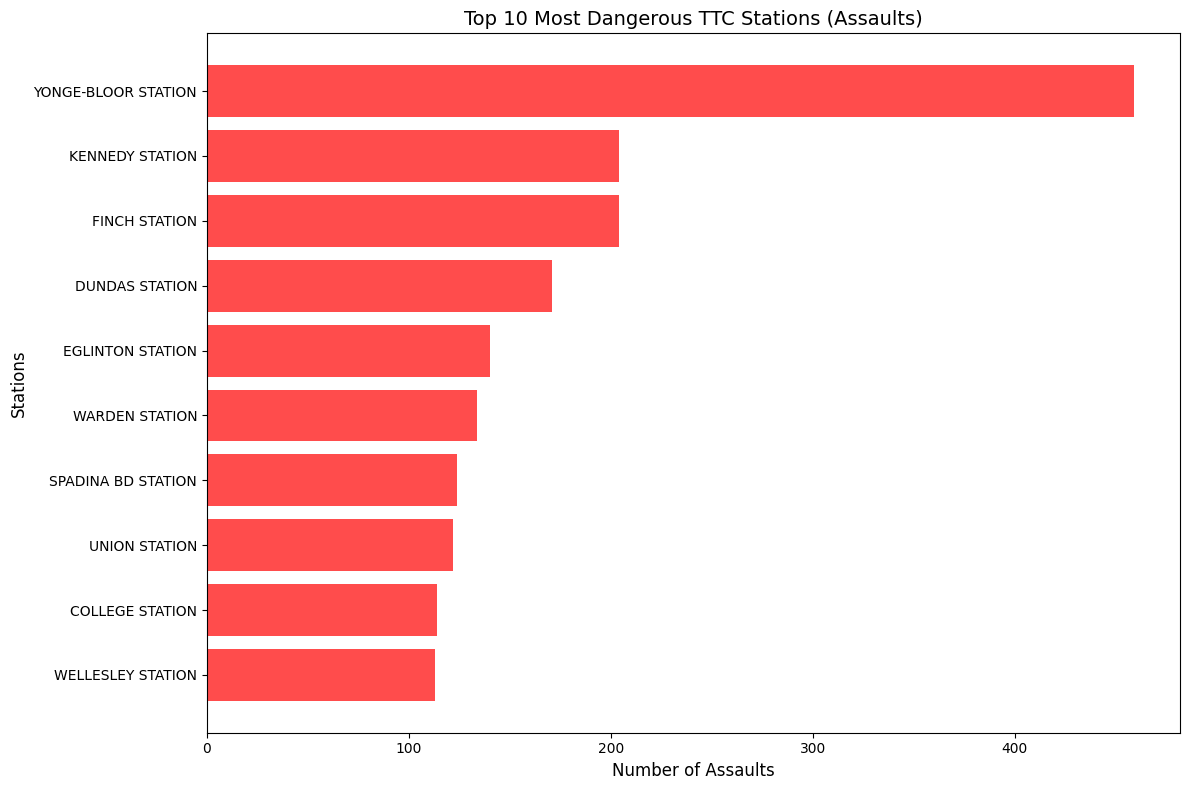

In [ ]:
# Define keywords related to assault or violence
assault_keywords = ["assault", "violent", "attack"]

# Filter delay codes for assault-related incidents based on descriptions
assault_codes = delay_codes[
    delay_codes["CODE DESCRIPTION"].str.contains("|".join(assault_keywords), case=False, na=False)
]

assault_code_list = assault_codes[["SUB RMENU CODE", "CODE DESCRIPTION"]]
assault_data = ttc_delays[ttc_delays["Code"].isin(assault_code_list["SUB RMENU CODE"])]
assault_station_counts = assault_data.groupby("Station").size().reset_index(name="Assault Count")
assault_station_counts_sorted = assault_station_counts.sort_values(by="Assault Count", ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(assault_station_counts_sorted.head(10)["Station"],
         assault_station_counts_sorted.head(10)["Assault Count"],
         color="red", alpha=0.7)
plt.xlabel("Number of Assaults", fontsize=12)
plt.ylabel("Stations", fontsize=12)
plt.title("Top 10 Most Dangerous TTC Stations (Assaults)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.tight_layout()
plt.show()
